# **Stock Price Forecasting**
Name: Goh Pin Pin Isaac<br>
Admin Number: P2317623<br>
Class: DAAA/FT/1B/07<br>
<br>

# **Project Objective**
<hr>

Using the Stock Price Dataset to train time series models and forecast the stock price of **Apple**, **Amazon** and **DBS** for the **next 60 days**

# **Background**
<hr>

With the Stock market always growing, its hard to predict the actual prices to make the most profit and investment in the stocks.<br>
Investors may use stock price predictions to implement hedging strategies to offset potential losses. <br>
Predicting stock prices aids in assessing and managing risks associated with investments. <br>
Understanding potential price movements helps investors develop strategies to protect their portfolios from market volatility.
<br><br>

This is a dataset collected from the stock price of **Apple**, **Amazon** and **DBS**. 
The dataset consists of the **closing** sale of the 3 Companies
<hr>

### Time Series model performance:
- r2 score
- explained variance score 
- mean squared error
- mean absolute error
- mean absolute percentage error

### Models for Time Series
- Simple Moving Average (SMA)
- Holt-Winter's Seasonal/Exponential Smoothing Model
- ARIMA
- SARIMAX

In [1]:
# Importing Modules
import pandas as pd
import numpy as np
import seaborn as sns

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Exploritory Libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Feature Engineering
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA

# Model Evaluation
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Models
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Others
import pickle
import statsmodels.stats.api as sm

In [2]:
# Set the SEED for random (Same Random results when re-ran)
random_state = 17

In [3]:
# Set the Style of the plots
plt.style.use('seaborn-v0_8-darkgrid')

In [4]:
import warnings
warnings.filterwarnings("ignore")

# 1. Importing CSV

In [5]:
# dataset = pd.read_csv('./CA2-Dataset/CA2-Stock-Price-Data.csv', sep=',')
dataset = pd.read_csv('./CA2-Dataset/CA2-Stock-Price-Data.csv', sep=',')
dataset.head()

,Date,Apple,Amazon,DBS
0,10/1/2018,56.814999,100.218002,25.969999
1,10/2/2018,57.320000,98.565498,25.629999
2,10/3/2018,58.017502,97.638000,25.950001
3,10/4/2018,56.997501,95.471001,25.760000
4,10/5/2018,56.072498,94.482498,25.770000


# Exploratory Data Analysis
This is a dataset collected from the stock price of **Apple**, **Amazon** and **DBS**. it contains 1257 records with 3 fields(floats).

- **Date    :** Date of the Price
- **Apple   :** Closing Stock Price (Apple)
- **Amazon  :** Closing Stock Price (Amazon)
- **DBS     :** Closing Stock Price (DBS)

## Functions used
- df.shape
- df.info()
- df.describe()
- df.unique()

### Data Exploration

In [6]:
dataset_eda = dataset.copy()
dataset_eda["Date"] = pd.to_datetime(dataset_eda["Date"])
dataset_eda = dataset_eda.set_index("Date").asfreq('d')

In [7]:
dataset_eda.shape

(1824, 3)

In [8]:
dataset_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1824 entries, 2018-10-01 to 2023-09-28
Freq: D
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Apple   1257 non-null   float64
 1   Amazon  1257 non-null   float64
 2   DBS     1257 non-null   float64
dtypes: float64(3)
memory usage: 57.0 KB


In [9]:
dataset_eda.isnull().sum()

Apple     567
Amazon    567
DBS       567
dtype: int64

## Notice that because our date is not the correct freqency, we now have alot of missing values
- we use forward fill because there is not much change from the previous day

In [10]:
dataset_eda = dataset_eda.ffill()
dataset_eda.isnull().sum()

Apple     0
Amazon    0
DBS       0
dtype: int64

In [11]:
dataset_eda.describe()

,Apple,Amazon,DBS
count,1824.000000,1824.000000,1824.000000
mean,116.076928,124.595720,28.190954
std,46.984382,32.507527,4.733518
min,35.547501,67.197998,16.879999
25%,66.923124,93.449997,24.900000
50%,129.675003,120.515252,28.505000
75%,152.555004,158.080250,32.470001
max,196.449997,186.570496,37.250000


# Visualizing Time Series

In [12]:
fig = px.line(dataset_eda, x=dataset_eda.index, y=dataset_eda.columns, labels={"value": "Closing Prices ($)"})
fig.update_layout(
    title={
    'text': "Time Series of Stock Prices",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    ))
fig.show()

**Conclusion**:
- Amazon: Rose to $170+ then dropped again
- Apple: Increaing Trend from $50 to $200
- DBS: Quite Stable around $50

# Univariate Analysis
explores each variable in the dataset, separately (Amzon | Apple | DBS)

In [13]:
fig = px.box(dataset_eda, y=dataset_eda.columns, points="all", labels={"value": "Closing Prices ($)"})
fig.update_layout(
    title={
    'text': "Time Series of Stock Prices",
    'y':0.95,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    ))
fig.show()

<hr>

# Time Series Analysis
- Stationarity (Stationary | Non-Stationary)
- Autocorrelation Analysis
- Seasonal Decomposition

This is to better understand our Time Series to choose the right model to get the best prediction

<hr>

# Stationarity (Augmented Dicky Fuller Test)

Let H0 be Data is not stationary<br>
Let H1 be Data is stationary

- P-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- P-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

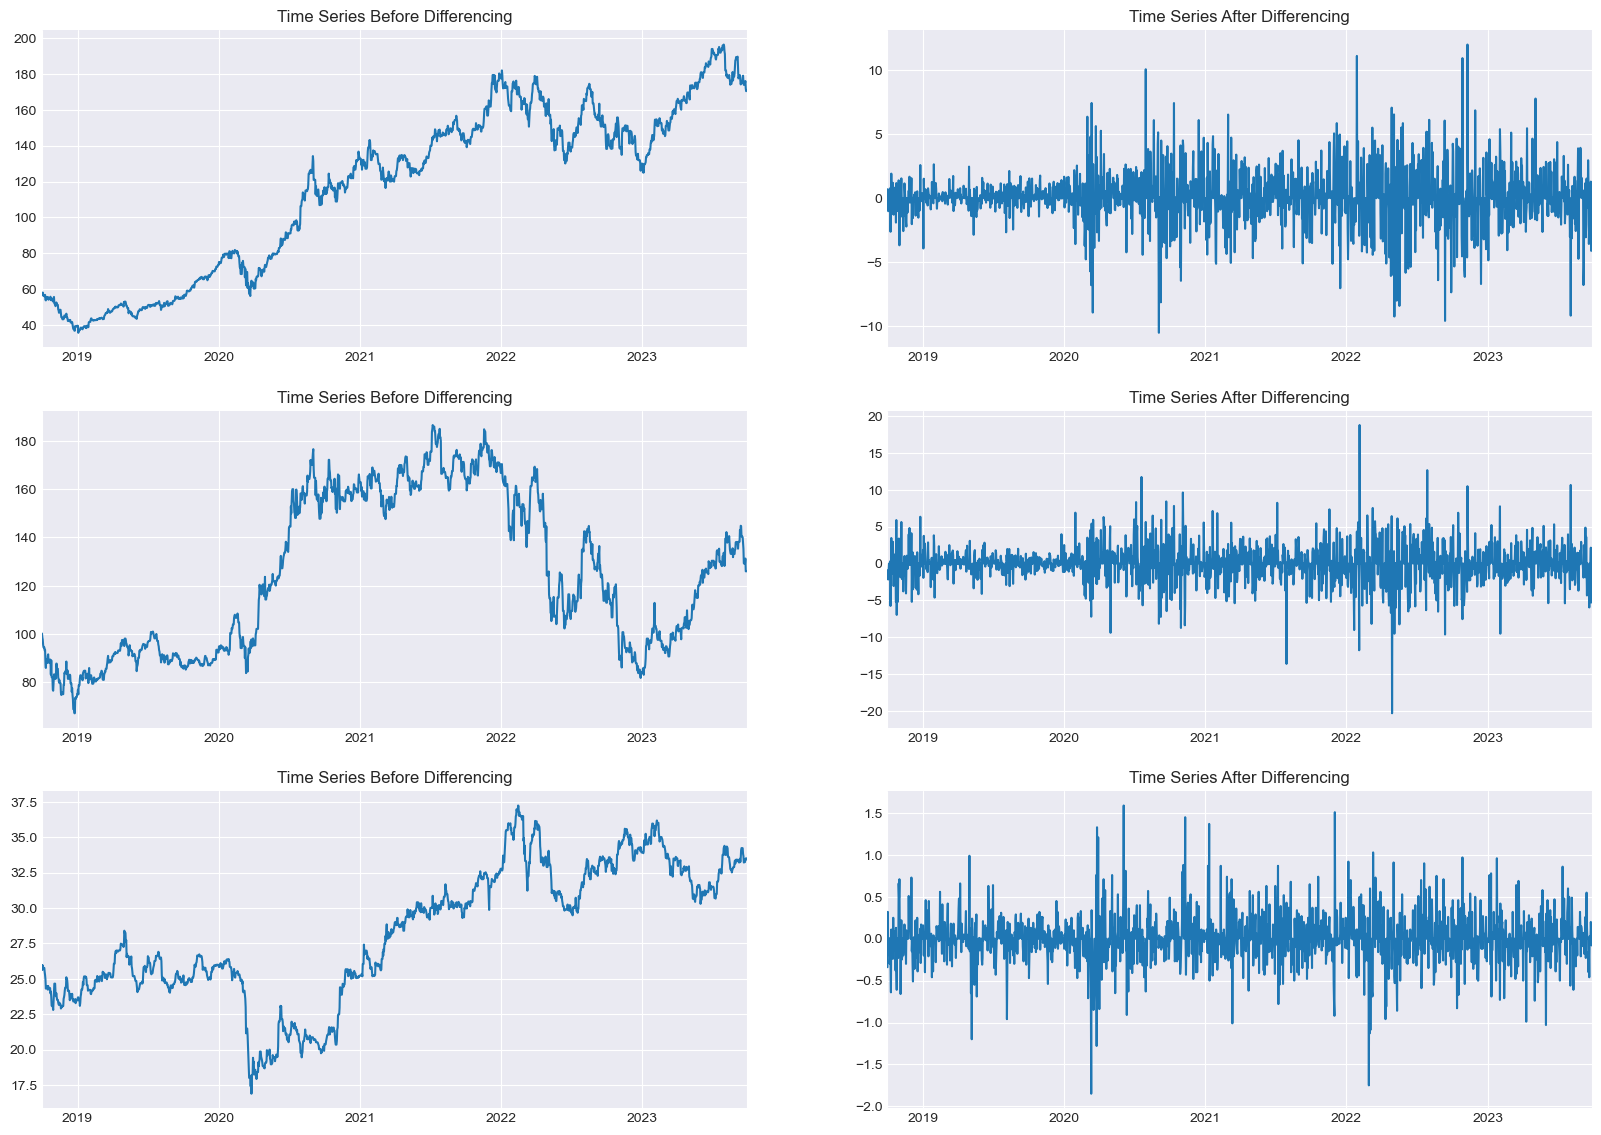

,BEFORE-P-Value,BEFORE-Stationary,AFTER-P-Value,AFTER-Stationary
Company,,,,
Apple,0.759123,False,3.801575e-15,True
Amazon,0.495835,False,0.000000e+00,True
DBS,0.643888,False,3.895166e-24,True


In [14]:
fig, ax = plt.subplots(3, 2, figsize=(20, 14))
before = {
    "Company": [],
    "BEFORE-P-Value": [],
    "BEFORE-Stationary": []
}
after = {
    "Company": [],
    "AFTER-P-Value": [],
    "AFTER-Stationary": []
}
for index, col in enumerate(dataset_eda.columns):
    # perform differencing operation
    df_diff = diff(dataset_eda[col], k_diff=1)
    result1 = adfuller(dataset_eda[col])
    result2 = adfuller(df_diff)
    before["Company"] += [col]
    before["BEFORE-P-Value"] += [result1[1]]
    before["BEFORE-Stationary"] += [False if result1[1] >= 0.05 else True]
    after["Company"] += [col]
    after["AFTER-P-Value"] += [result2[1]]
    after["AFTER-Stationary"] += [False if result2[1] >= 0.05 else True]

    dataset_eda[col].plot(ax=ax[index, 0])
    df_diff.plot(ax=ax[index, 1])
    ax[index, 0].set_title('Time Series Before Differencing')
    ax[index, 1].set_title('Time Series After Differencing')
    ax[index, 0].set_xlabel("")
    ax[index, 1].set_xlabel("")
total = pd.merge(pd.DataFrame(before), pd.DataFrame(after), how="left", on="Company")
total.set_index("Company", inplace=True)
plt.show()
total

# **Conclusion:**

### Before 
- Before **all** the Companies P-Values where greater than 0.5 
- Not Stationary

### After
- After Difference - **All** the P-Values are significantly less than 0.5
- Stationary

<hr>

# Seasonal Decomposition

Time Series is made up of a Sum or Product of three components 
- Linear Trend
- Seasonal Component
- Random Residuals.

Seasonal Decomposition
Column: Apple
Seasonal 7


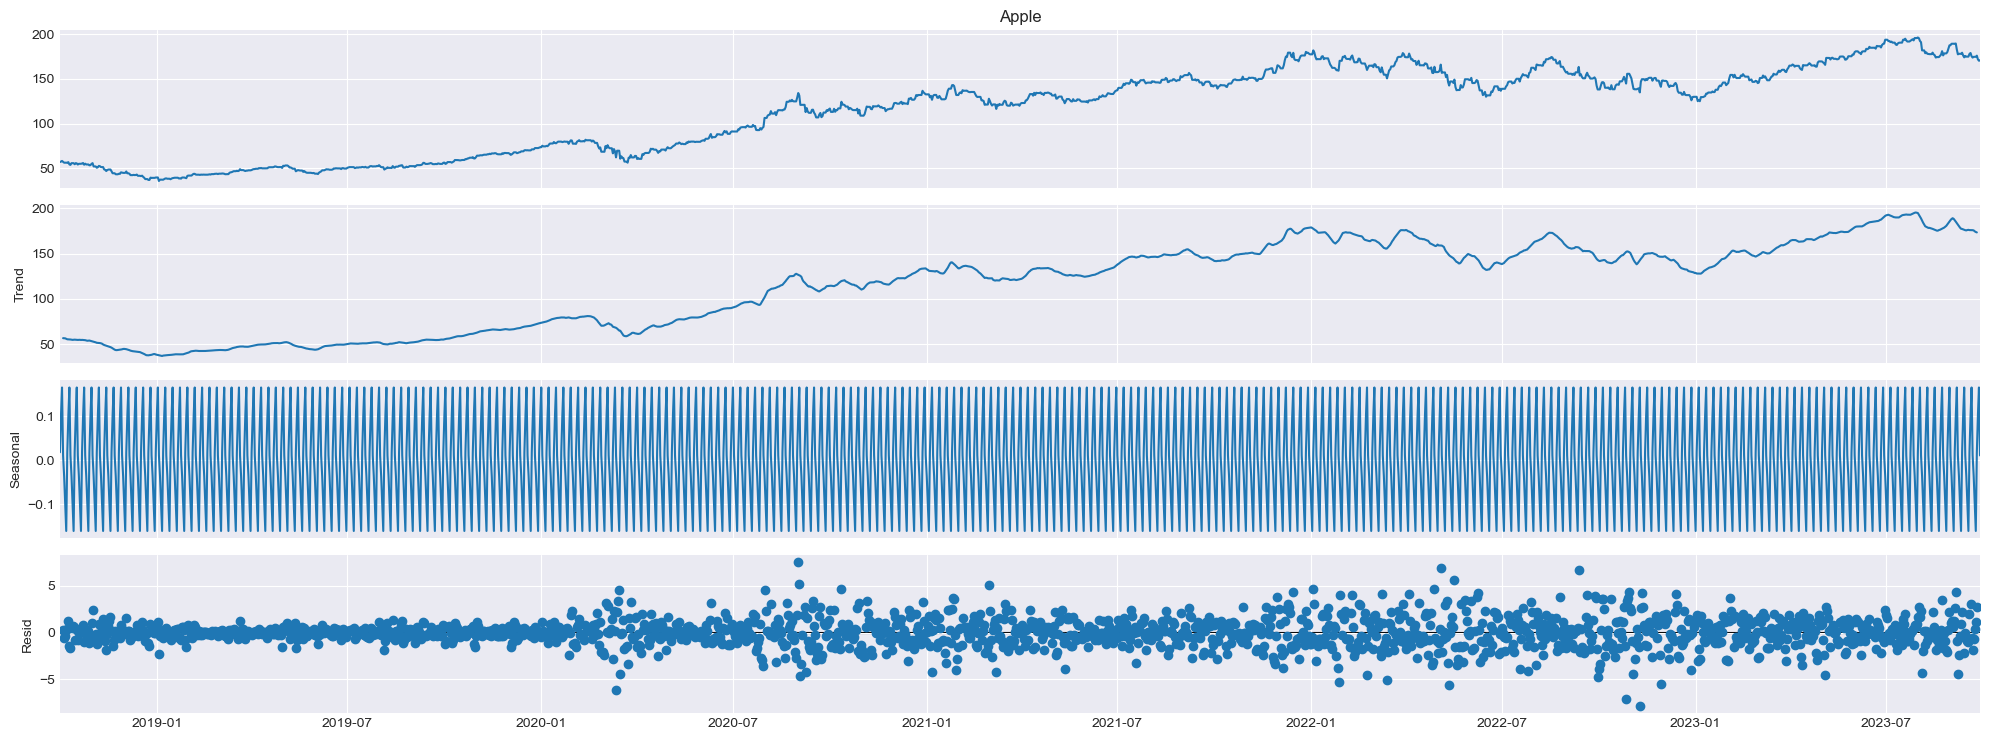

Seasonal Decomposition
Column: Amazon
Seasonal 7


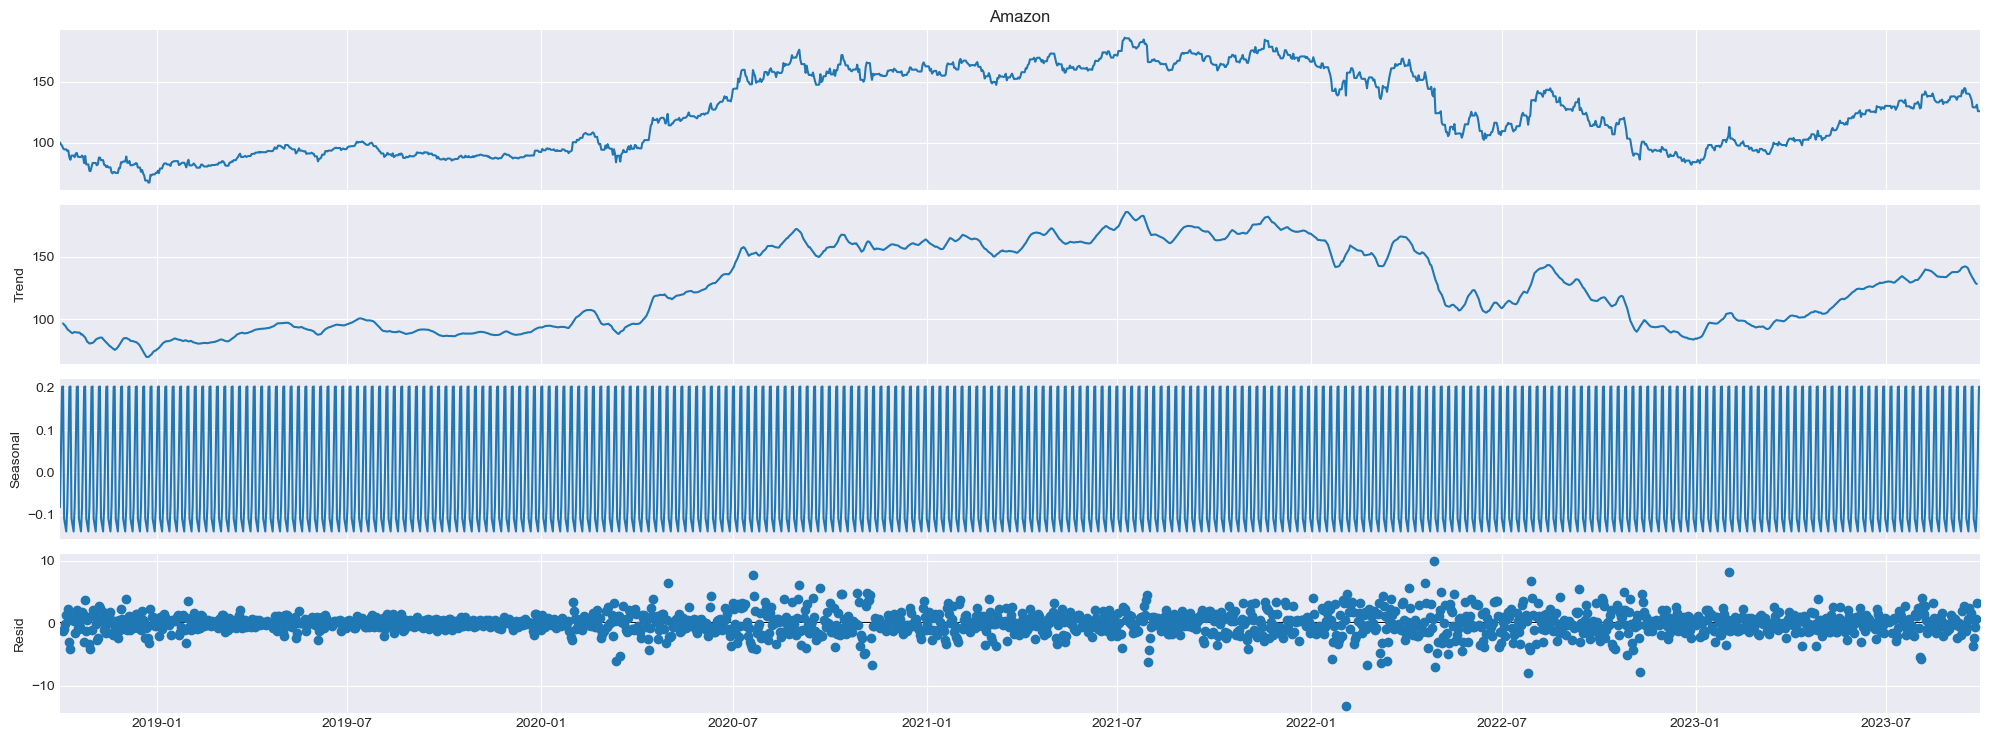

Seasonal Decomposition
Column: DBS
Seasonal 7


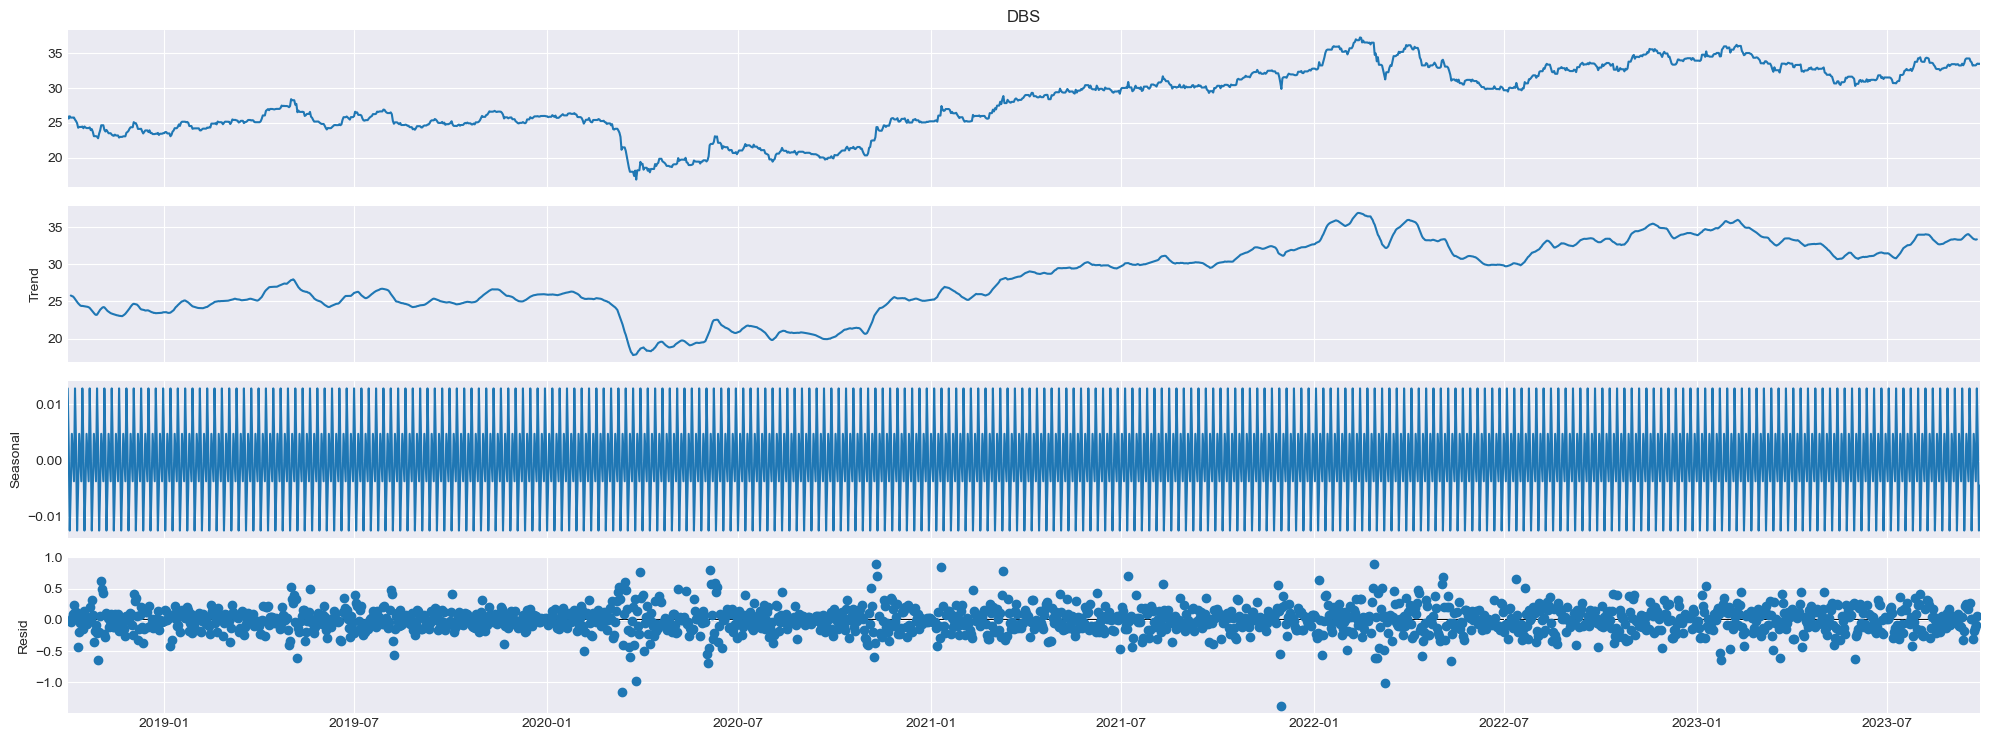

In [15]:
for i in dataset_eda.columns:
    plt.rc("figure", figsize=(20, 7.5))
    print("Seasonal Decomposition\nColumn:", i)
    decomposition = seasonal_decompose(dataset_eda[i], model='additive')
    decomposition.plot()
    print("Seasonal", len(decomposition.seasonal.drop_duplicates()))
    plt.show()

## **Conclusion:**
### **<u>Seasonality is 7</u>**
- **Apple**
    - Positive Linear Trend
    - Strong Seasonality
    - Residual Moves up and down a lot (many Outliers)
- **Amazon**
    - Rose but Fell
    - Strong Seasonality
    - Residual Moves up and down a lot (many Outliers)
- **DBS**
    - Fell but Rose
    - Strong Seasonality
    - Residual Moves up and down a lot (many Outliers)

<hr>

# Autocorrelation Analysis
- **Autocorrelation (ACF):** the degree of correlation of the same variables between two successive time intervals (lagged version).
- **Partial Autocorrelation (PACF):** the degree of correlation of the same variables between two successive time intervals (lagged version) excluding the contributions from intermediate lags

ACF & PACF generally produce plots that are very important in finding the values p, q and r for Autoregressive (AR) and Moving Average (MA) models

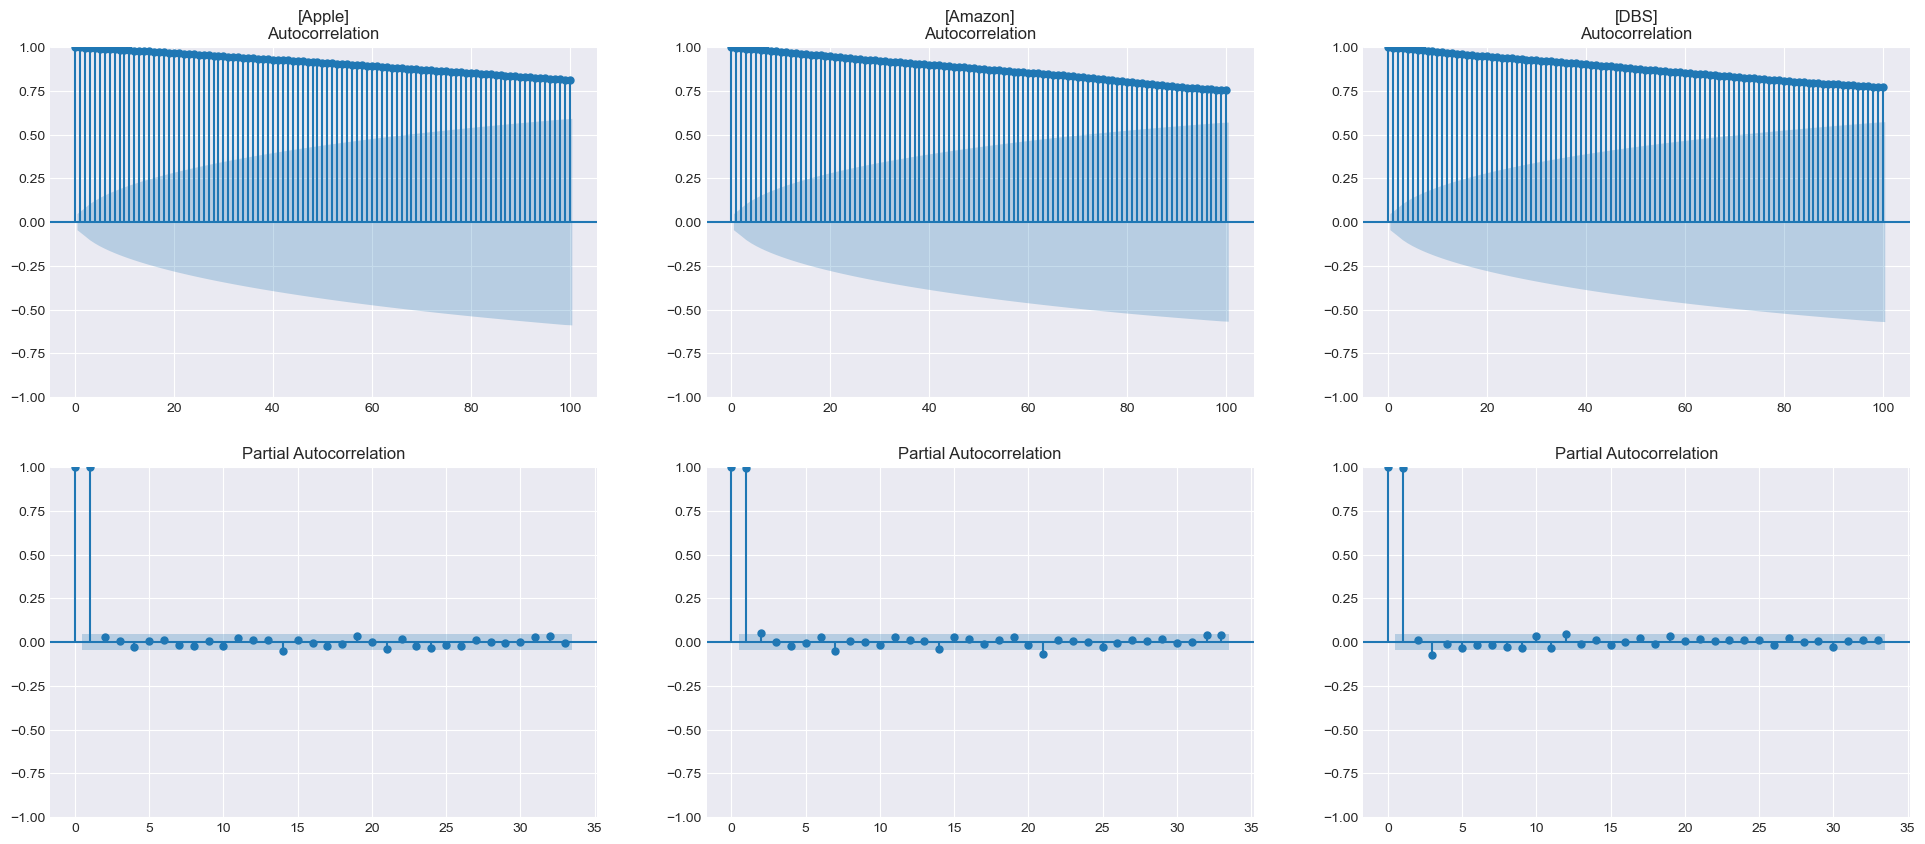

In [16]:
# Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(2,3, figsize = (24,10))
for idx, variable in enumerate(dataset_eda):
    plot_acf(dataset_eda[variable], ax = axes[0, idx], lags=100) # Looks for MA(q)
    plot_pacf(dataset_eda[variable], method='ywm', ax = axes[1, idx]) # Looks for AR(p)
    axes[0, idx].set_title("[{}]\nAutocorrelation".format(variable))
plt.show()

# **Conclusion**

### <u>Autocorrelation Function:</u>
- **Slow decaying ACF**, we are likely dealing with an Auto Regressive Process
- if Strong lines then sudden drop = Moving average 


### <u>Partial Autocorrelation Function:</u>
- PACF We should start our Auto Regressive model with lag **1**

# Dataset Processing
we need to prepare and process our data so our model can be better fit with the data

In [17]:
# Setting Datetime for TimeSeries
dataset = pd.read_csv('./CA2-Dataset/CA2-Stock-Price-Data.csv', sep=',')
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset = dataset.set_index("Date").asfreq('d')

# Imputing Data
dataset = dataset.bfill()

Since we change the date frequency to “Day”, there are some null values. <br>
Hence, we use BackFill or FrontFill in order to get the previous stock price. <br>
This is more accurate as when we have null values, the stock market closes and doesn’t change.

In [18]:
# Splitting the data to predict the last 60days
train_data = dataset[:-60]
test_data = dataset[-60:]
print(f"train: {train_data.shape}")
print(f"test: {test_data.shape}")

train: (1764, 3)
test: (60, 3)


In [19]:
temp_dataset = dataset.copy()

# ARIMA - order[1,1,0] **(Baseline)**

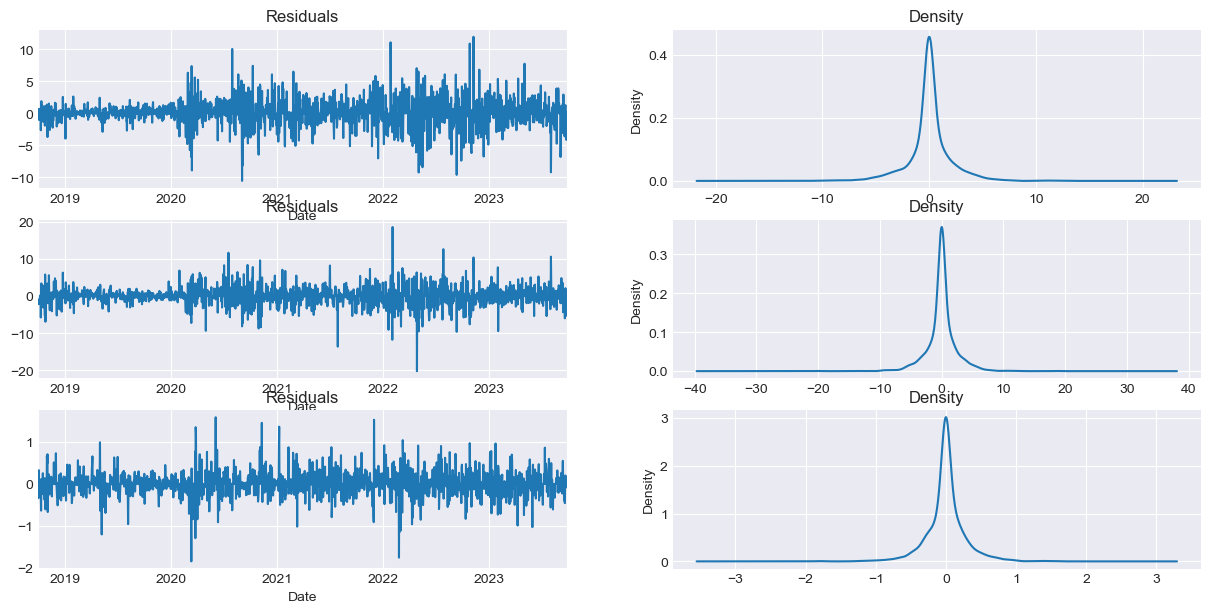

In [54]:
model_apple = ARIMA(temp_dataset["Apple"], order=(1,1,0))
model_fit_apple = model_apple.fit()
model_amazon = ARIMA(temp_dataset["Amazon"], order=(1,1,0))
model_fit_amazon = model_amazon.fit()
model_dbs = ARIMA(temp_dataset["DBS"], order=(1,1,0))
model_fit_dbs = model_dbs.fit()


residuals_apple = model_fit_apple.resid[1:]
residuals_amazon = model_fit_amazon.resid[1:]
residuals_dbs = model_fit_dbs.resid[1:]

fig, ax = plt.subplots(3,2, figsize=(15,7))
residuals_apple.plot(title='Residuals', ax=ax[0,0])
residuals_apple.plot(title='Density', kind='kde', ax=ax[0,1])

residuals_amazon.plot(title='Residuals', ax=ax[1,0])
residuals_amazon.plot(title='Density', kind='kde', ax=ax[1,1])

residuals_dbs.plot(title='Residuals', ax=ax[2,0])
residuals_dbs.plot(title='Density', kind='kde', ax=ax[2,1])
plt.show()

<Axes: xlabel='Date'>

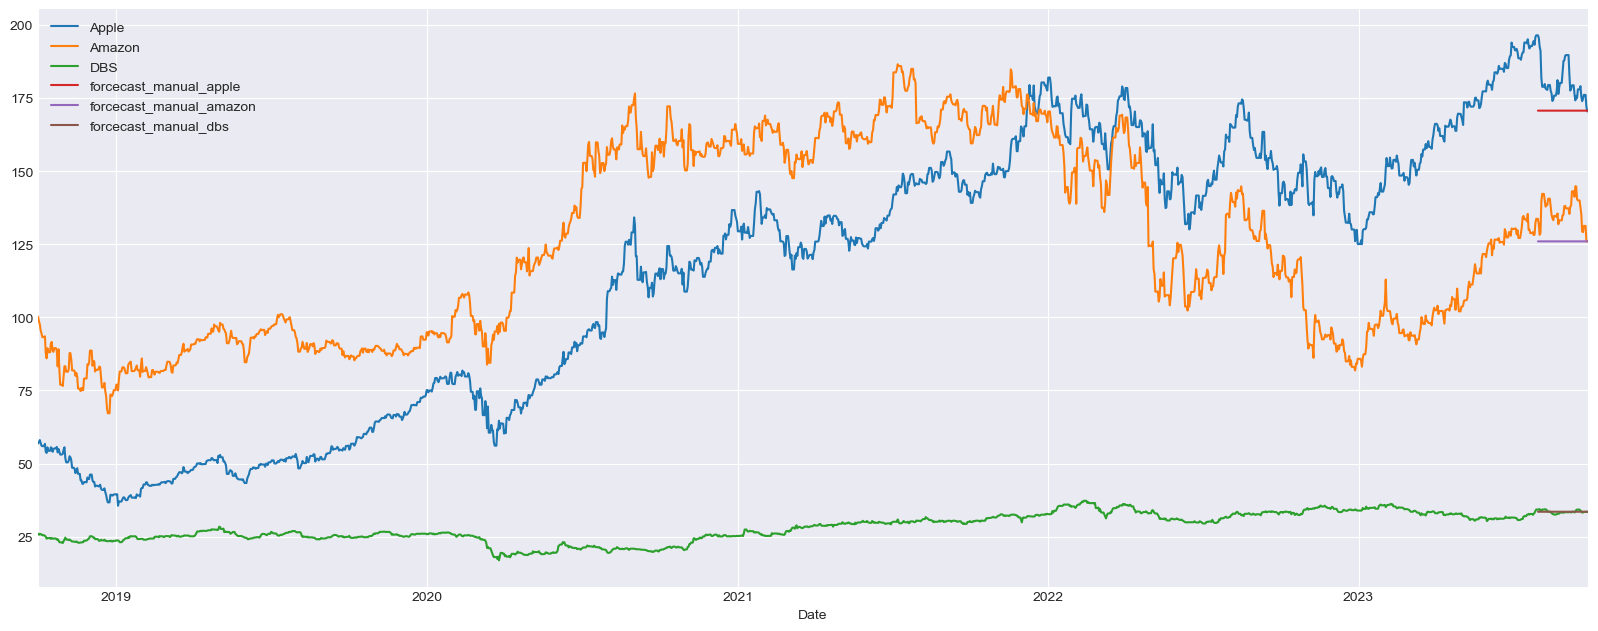

In [55]:
forecast_test_apple = model_fit_apple.forecast(len(test_data))
temp_dataset["forcecast_manual_apple"] = [None]*len(train_data) + list(forecast_test_apple)

forecast_test_amazon = model_fit_amazon.forecast(len(test_data))
temp_dataset["forcecast_manual_amazon"] = [None]*len(train_data) + list(forecast_test_amazon)

forecast_test_dbs = model_fit_dbs.forecast(len(test_data))
temp_dataset["forcecast_manual_dbs"] = [None]*len(train_data) + list(forecast_test_dbs)
temp_dataset.plot()

# **Holt Winter's Exponential Smoothing**

In [35]:
HWES_dic = {
    'stock': [],
    'train_r2_score': [],
    'train_explained_variance_score': [],
    'train_mean_squared_error': [],
    'train_mean_absolute_error': [],
    'train_mean_absolute_percentage_error': [],

    'test_r2_score': [],
    'test_explained_variance_score': [],
    'test_mean_squared_error': [],
    'test_mean_absolute_error': [],
    'test_mean_absolute_percentage_error': []
}

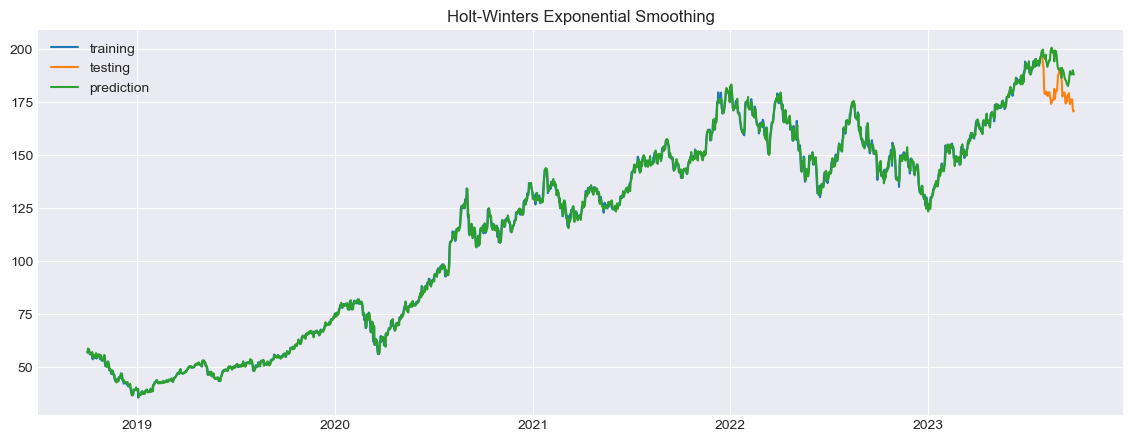

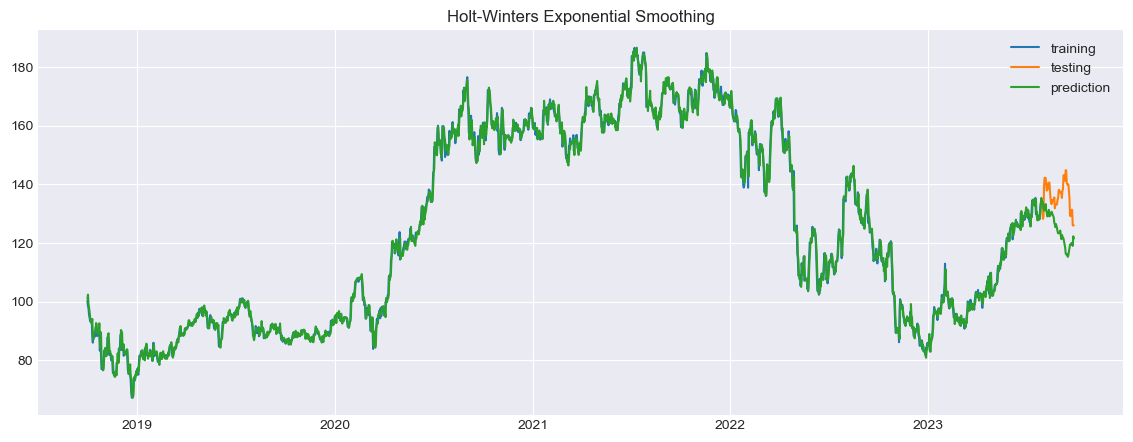

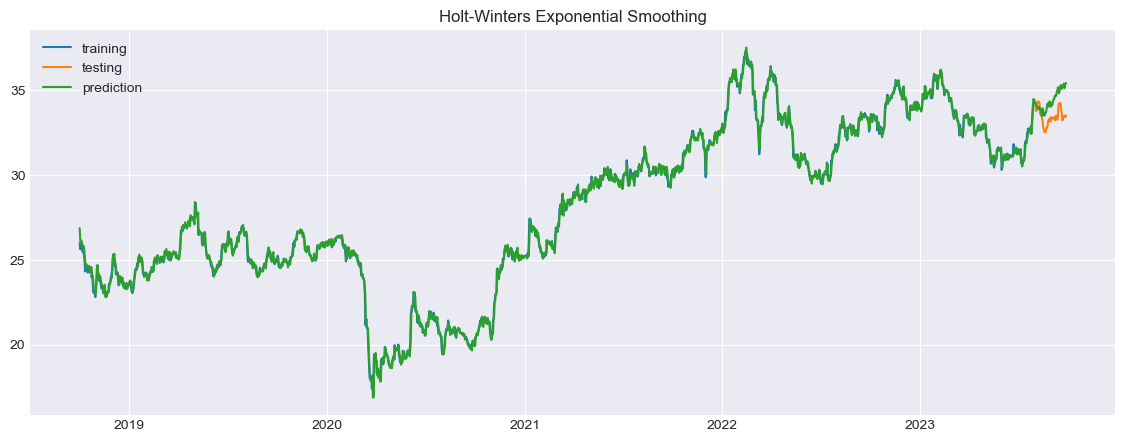

In [36]:
for col in ['Apple', 'Amazon', 'DBS']:
    es_model = HWES(train_data[col], seasonal_periods=300, trend='mul', seasonal='mul', damped_trend=True, freq='D').fit()
    pred1 = es_model.predict(start=temp_dataset.index.min(), end=temp_dataset.index.max())
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(train_data[col], label='training')
    ax.plot(test_data[col], label='testing')
    ax.plot(pred1, label='prediction')
    plt.legend()
    plt.title('Holt-Winters Exponential Smoothing')
    plt.show()

    # Evaluation
    HWES_dic['stock'] += [col] 
    HWES_dic['train_r2_score'] += [r2_score(train_data[col], pred1[:-60])]
    HWES_dic['train_explained_variance_score'] += [explained_variance_score(train_data[col], pred1[:-60])]
    HWES_dic['train_mean_squared_error'] += [mean_squared_error(train_data[col], pred1[:-60])]
    HWES_dic['train_mean_absolute_error'] += [mean_absolute_error(train_data[col], pred1[:-60])]
    HWES_dic['train_mean_absolute_percentage_error'] += [mean_absolute_percentage_error(train_data[col], pred1[:-60])]

    HWES_dic['test_r2_score'] += [r2_score(test_data[col], pred1[-60:])]
    HWES_dic['test_explained_variance_score'] += [explained_variance_score(test_data[col], pred1[-60:])]
    HWES_dic['test_mean_squared_error'] += [mean_squared_error(test_data[col], pred1[-60:])]
    HWES_dic['test_mean_absolute_error'] += [mean_absolute_error(test_data[col], pred1[-60:])]
    HWES_dic['test_mean_absolute_percentage_error'] += [mean_absolute_percentage_error(test_data[col], pred1[-60:])]

In [37]:
HWES_results = pd.DataFrame(HWES_dic)
HWES_results.set_index("stock",inplace=True)
HWES_results[['test_r2_score','test_explained_variance_score','test_mean_squared_error','test_mean_absolute_error','test_mean_absolute_percentage_error']]

,test_r2_score,test_explained_variance_score,test_mean_squared_error,test_mean_absolute_error,test_mean_absolute_percentage_error
stock,,,,,
Apple,-4.693791,-0.404603,197.162758,12.298759,0.069260
Amazon,-7.532892,-1.595472,187.268934,11.774543,0.085355
DBS,-3.815863,-0.696313,1.243408,0.970426,0.029079


# **Arima**

In [26]:
import itertools

p_values = range(0, 5)  # Example range for p
d_values = range(1, 3)  # Example range for d
q_values = range(0, 5)  # Example range for q

dic = {
    'stock': [],
    'order': [],
    'r2_score': [],
    'explained_variance_score': [],
    'mean_squared_error': [],
    'mean_absolute_error': [],
    'mean_absolute_percentage_error': []
}

for col in train_data.columns:
    temp_stock = []
    temp_order = []
    temp_r2_score = []
    temp_explained_variance_score = []
    temp_mean_squared_error = []
    temp_mean_absolute_error = []
    temp_mean_absolute_percentage_error = []
    for p, d, q in itertools.product(p_values, d_values, q_values):
        model = ARIMA(train_data[col], order=(p, d, q))
        result = model.fit()
        predictions = result.forecast(steps=len(test_data))

        temp_stock += [col]
        temp_order += [(p, d, q)]
        temp_r2_score += [r2_score(test_data[col], predictions)]
        temp_explained_variance_score += [explained_variance_score(test_data[col], predictions)]
        temp_mean_squared_error += [mean_squared_error(test_data[col], predictions)]
        temp_mean_absolute_error += [mean_absolute_error(test_data[col], predictions)]
        temp_mean_absolute_percentage_error += [mean_absolute_percentage_error(test_data[col], predictions)]

    index = temp_r2_score.index(max(temp_r2_score))

    dic['stock'] += [temp_stock[index]]
    dic['order'] += [temp_order[index]]
    dic['r2_score'] += [temp_r2_score[index]]
    dic['explained_variance_score'] += [temp_explained_variance_score[index]]
    dic['mean_squared_error'] += [temp_mean_squared_error[index]]
    dic['mean_absolute_error'] += [temp_mean_absolute_error[index]]
    dic['mean_absolute_percentage_error'] += [temp_mean_absolute_percentage_error[index]]

arima_result = pd.DataFrame(dic)

In [27]:
arima_result

,stock,order,r2_score,explained_variance_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Apple,"(3, 1, 1)",-7.662275,0.003834,299.954468,16.296276,0.091703
1,Amazon,"(4, 2, 3)",-0.180732,-0.027864,25.913197,4.171371,0.030434
2,DBS,"(1, 1, 2)",-2.153725,-0.000455,0.814261,0.756181,0.022796


                               SARIMAX Results                                
Dep. Variable:                  Apple   No. Observations:                 1764
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -3684.676
Date:                Fri, 09 Feb 2024   AIC                           7379.352
Time:                        11:26:24   BIC                           7406.726
Sample:                    10-01-2018   HQIC                          7389.468
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5294      0.266      1.987      0.047       0.007       1.052
ar.L2          0.0061      0.021      0.295      0.768      -0.034       0.046
ar.L3         -0.0394      0.024     -1.656      0.0

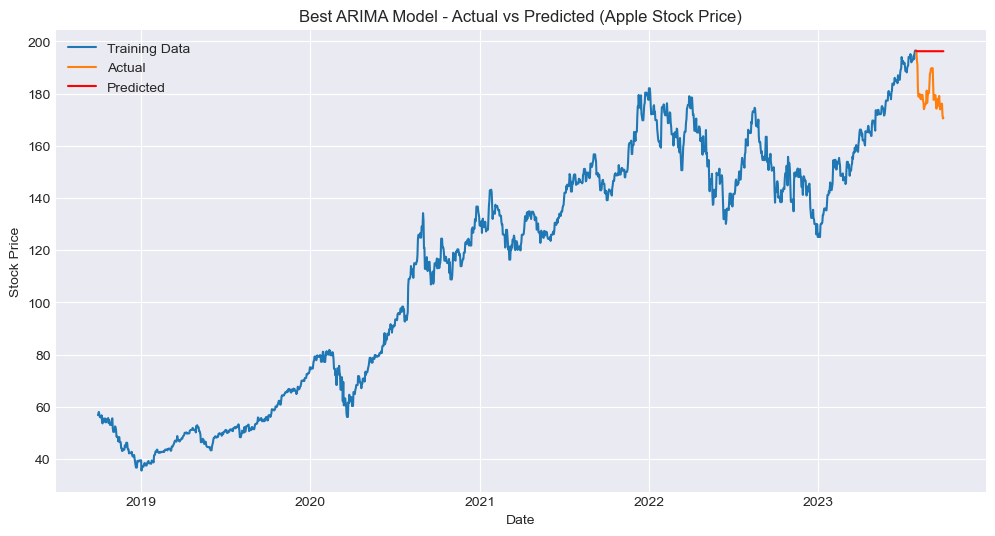

                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1764
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -4012.313
Date:                Fri, 09 Feb 2024   AIC                           8040.625
Time:                        11:26:27   BIC                           8084.419
Sample:                    10-01-2018   HQIC                          8056.808
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8047      0.018   -100.277      0.000      -1.840      -1.769
ar.L2         -0.9984      0.037    -26.973      0.000      -1.071      -0.926
ar.L3          0.0070      0.045      0.157      0.8

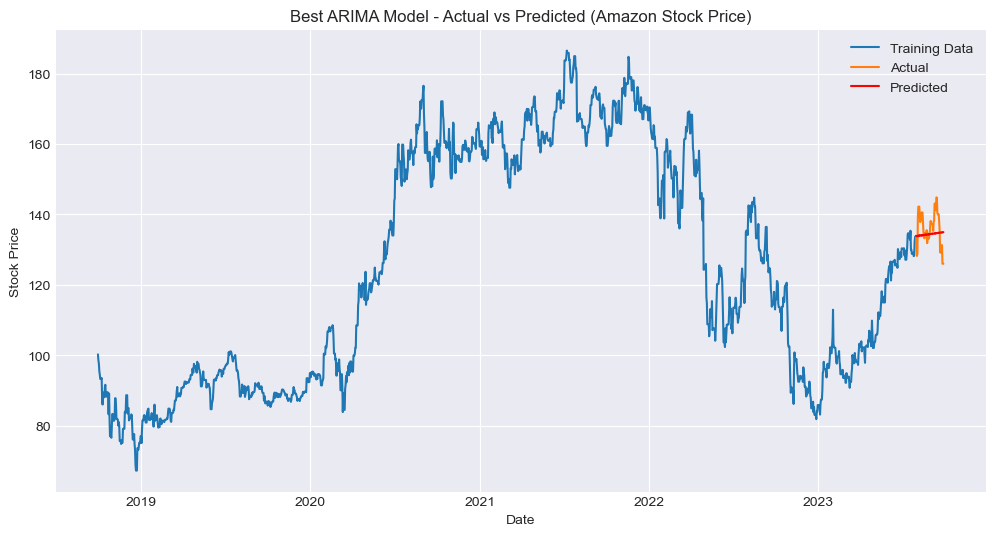

                               SARIMAX Results                                
Dep. Variable:                    DBS   No. Observations:                 1764
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -240.283
Date:                Fri, 09 Feb 2024   AIC                            488.565
Time:                        11:26:27   BIC                            510.464
Sample:                    10-01-2018   HQIC                           496.657
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8883      0.067    -13.196      0.000      -1.020      -0.756
ma.L1          0.9024      0.070     12.880      0.000       0.765       1.040
ma.L2          0.0452      0.020      2.269      0.0

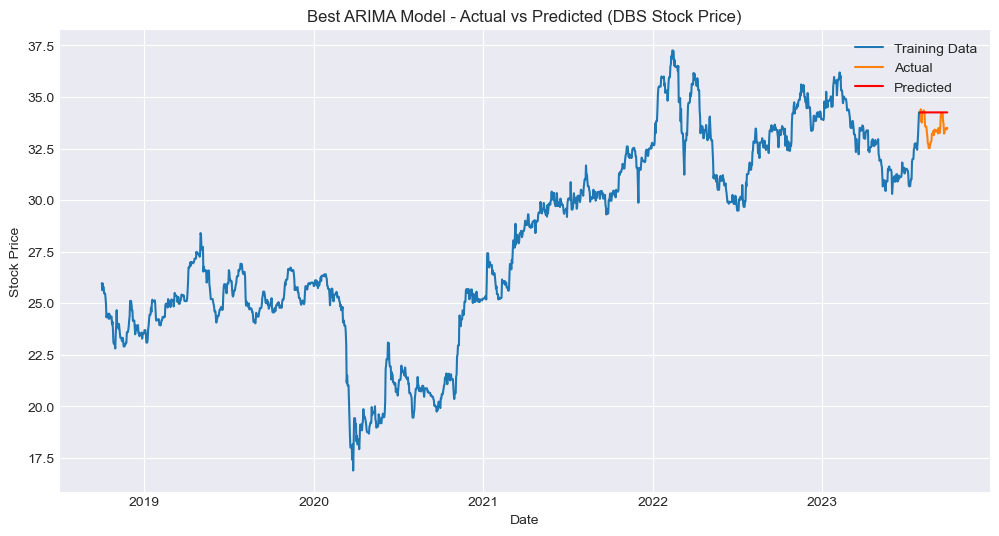

In [28]:
for index, col in enumerate(["Apple","Amazon","DBS"]):
    # Fit ARIMA model with the best parameters
    best_model = ARIMA(train_data[col], order= arima_result[arima_result["stock"] == col]['order'][index])
    best_result = best_model.fit()

    # Print best model summary
    print(best_result.summary())

    # Make predictions on the testing set using the best model
    best_predictions = best_result.forecast(steps=len(test_data))

    # Plot actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[col], label='Training Data')
    plt.plot(test_data.index, test_data[col], label='Actual')
    plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
    plt.title(f'Best ARIMA Model - Actual vs Predicted ({col} Stock Price)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# **SARIMA**

In [29]:
from tqdm import tqdm
import itertools

season_dic = {
    'stock': [],
    'order': [],
    'seasonal_order': [],
    'r2_score': [],
    'explained_variance_score': [],
    'mean_squared_error': [],
    'mean_absolute_error': [],
    'mean_absolute_percentage_error': []
}

for col in dataset.columns:
    p_range = range(1,3)
    d_range = (1,)
    q_range = range(1,3)
    P_range = range(1,3)
    D_range = [1]
    Q_range = range(1,3)
    m = (7,)


    temp_stock = []
    temp_order = []
    temp_seasonal_order = []
    temp_r2_score = []
    temp_explained_variance_score = []
    temp_mean_squared_error = []
    temp_mean_absolute_error = []
    temp_mean_absolute_percentage_error = []
    
    for p, d, q, P, D, Q, m in tqdm(itertools.product(*(p_range, d_range, q_range, P_range, D_range, Q_range, m))):
        model=SARIMAX(dataset[col],order=(p, d, q),seasonal_order=(P, D, Q, m))
        result = model.fit()
        predictions = result.forecast(steps=len(test_data))

        temp_stock += [col]
        temp_order += [(p, d, q)]
        temp_seasonal_order += [(P, D, Q, m)]
        temp_r2_score += [r2_score(test_data[col], predictions)]
        temp_explained_variance_score += [explained_variance_score(test_data[col], predictions)]
        temp_mean_squared_error += [mean_squared_error(test_data[col], predictions)]
        temp_mean_absolute_error += [mean_absolute_error(test_data[col], predictions)]
        temp_mean_absolute_percentage_error += [mean_absolute_percentage_error(test_data[col], predictions)]

    index = temp_mean_absolute_percentage_error.index(min(temp_mean_absolute_percentage_error))

    season_dic['stock'] += [temp_stock[index]]
    season_dic['order'] += [temp_order[index]]
    season_dic['seasonal_order'] += [temp_seasonal_order[index]]
    season_dic['r2_score'] += [temp_r2_score[index]]
    season_dic['explained_variance_score'] += [temp_explained_variance_score[index]]
    season_dic['mean_squared_error'] += [temp_mean_squared_error[index]]
    season_dic['mean_absolute_error'] += [temp_mean_absolute_error[index]]
    season_dic['mean_absolute_percentage_error'] += [temp_mean_absolute_percentage_error[index]]

seasonal_result = pd.DataFrame(season_dic)

0it [00:00, ?it/s]

16it [01:28,  5.56s/it]
16it [01:23,  5.25s/it]
16it [01:26,  5.43s/it]


In [30]:
seasonal_result

,stock,order,seasonal_order,r2_score,explained_variance_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Apple,"(2, 1, 2)","(1, 1, 1, 7)",-1.290315,-0.381696,79.308309,6.624690,0.035918
1,Amazon,"(1, 1, 2)","(2, 1, 1, 7)",-3.564178,0.000060,100.168709,9.027516,0.065262
2,DBS,"(1, 1, 1)","(2, 1, 1, 7)",-0.091225,-0.043887,0.281743,0.450562,0.013467


                                      SARIMAX Results                                      
Dep. Variable:                               Apple   No. Observations:                 1824
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -3826.638
Date:                             Fri, 09 Feb 2024   AIC                           7667.276
Time:                                     11:30:51   BIC                           7705.807
Sample:                                 10-01-2018   HQIC                          7681.493
                                      - 09-28-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0248      0.030      0.834      0.404      -0.034       0.083
ar.L2          0.9436      

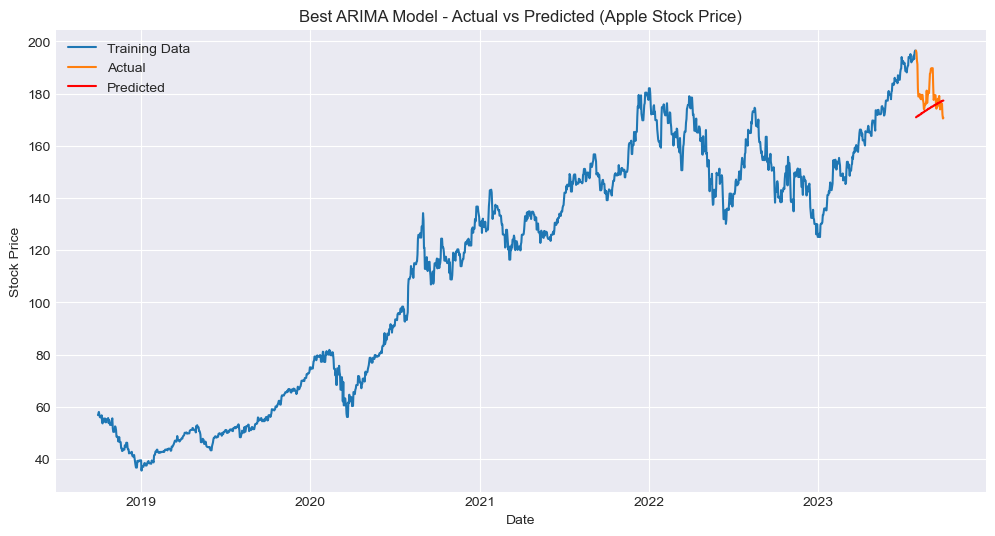

                                      SARIMAX Results                                      
Dep. Variable:                              Amazon   No. Observations:                 1824
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 7)   Log Likelihood               -4158.467
Date:                             Fri, 09 Feb 2024   AIC                           8330.935
Time:                                     11:30:55   BIC                           8369.465
Sample:                                 10-01-2018   HQIC                          8345.151
                                      - 09-28-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6555      1.550      0.423      0.672      -2.382       3.693
ma.L1         -0.6635      

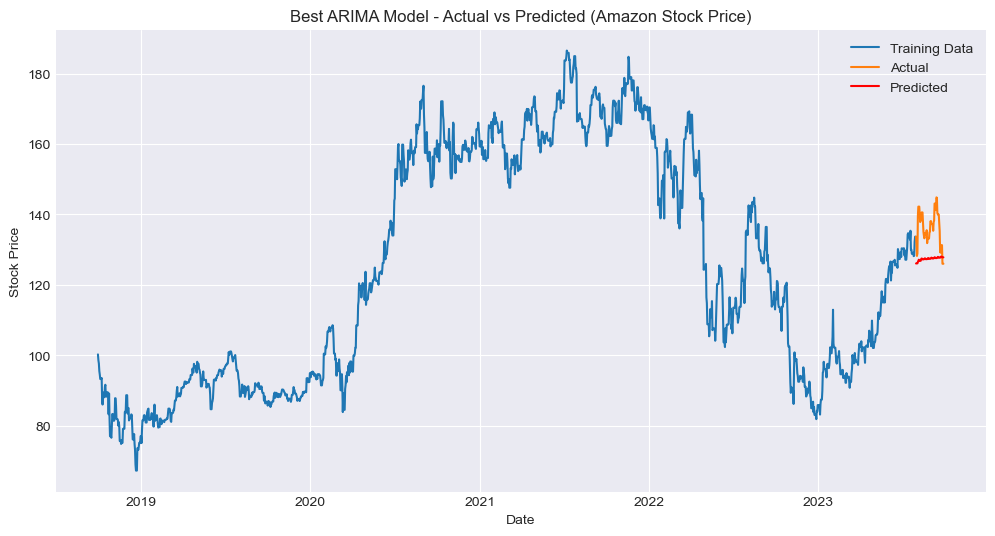

                                     SARIMAX Results                                     
Dep. Variable:                               DBS   No. Observations:                 1824
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood                -254.399
Date:                           Fri, 09 Feb 2024   AIC                            520.797
Time:                                   11:30:59   BIC                            553.823
Sample:                               10-01-2018   HQIC                           532.983
                                    - 09-28-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7995      0.152      5.270      0.000       0.502       1.097
ma.L1         -0.7694      0.161     -4.788

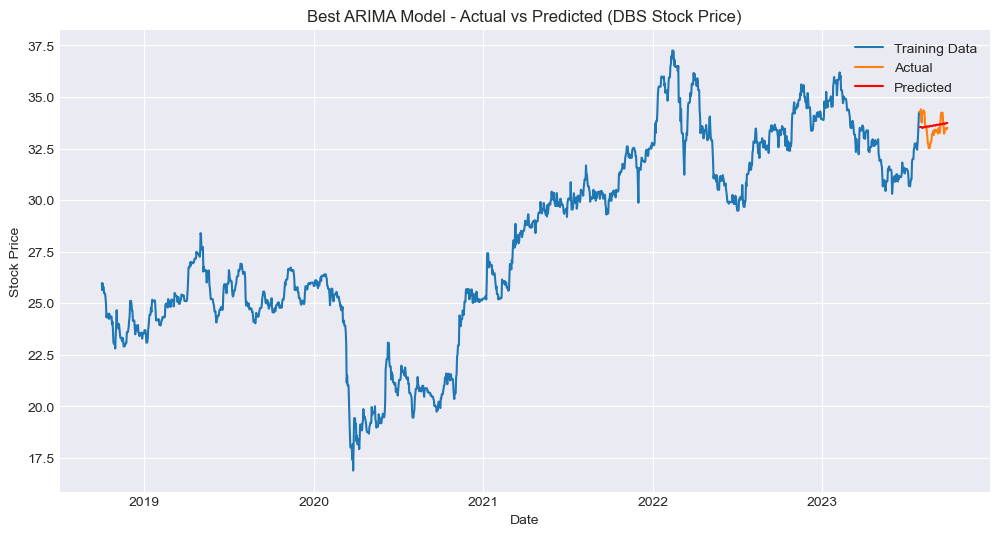

In [31]:
for index, col in enumerate(["Apple","Amazon","DBS"]):
    # Fit ARIMA model with the best parameters
    best_model=SARIMAX(dataset[col],order=seasonal_result[seasonal_result["stock"] == col]['order'][index],seasonal_order=seasonal_result[seasonal_result["stock"] == col]['seasonal_order'][index])
    best_result = best_model.fit()

    # Print best model summary
    print(best_result.summary())

    # Make predictions on the testing set using the best model
    best_predictions = best_result.forecast(steps=len(test_data))

    # Plot actual vs. predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(train_data[col], label='Training Data')
    plt.plot(test_data.index, test_data[col], label='Actual')
    plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
    plt.title(f'Best ARIMA Model - Actual vs Predicted ({col} Stock Price)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Total Results
From this:
- SARIMA has the lowest MAPE for Apple & DBS out of all
- ARIMA has  the lowest MAPE for Amazon out of it all

In [32]:
seasonal_result

,stock,order,seasonal_order,r2_score,explained_variance_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Apple,"(2, 1, 2)","(1, 1, 1, 7)",-1.290315,-0.381696,79.308309,6.624690,0.035918
1,Amazon,"(1, 1, 2)","(2, 1, 1, 7)",-3.564178,0.000060,100.168709,9.027516,0.065262
2,DBS,"(1, 1, 1)","(2, 1, 1, 7)",-0.091225,-0.043887,0.281743,0.450562,0.013467


In [33]:
arima_result

,stock,order,r2_score,explained_variance_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
0,Apple,"(3, 1, 1)",-7.662275,0.003834,299.954468,16.296276,0.091703
1,Amazon,"(4, 2, 3)",-0.180732,-0.027864,25.913197,4.171371,0.030434
2,DBS,"(1, 1, 2)",-2.153725,-0.000455,0.814261,0.756181,0.022796


In [46]:
HWES_results[['test_r2_score','test_explained_variance_score','test_mean_squared_error','test_mean_absolute_error','test_mean_absolute_percentage_error']]

,test_r2_score,test_explained_variance_score,test_mean_squared_error,test_mean_absolute_error,test_mean_absolute_percentage_error
stock,,,,,
Apple,-4.693791,-0.404603,197.162758,12.298759,0.069260
Amazon,-7.532892,-1.595472,187.268934,11.774543,0.085355
DBS,-3.815863,-0.696313,1.243408,0.970426,0.029079


# Model Evaluation

                                      SARIMAX Results                                      
Dep. Variable:                               Apple   No. Observations:                 1824
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -3826.638
Date:                             Fri, 09 Feb 2024   AIC                           7667.276
Time:                                     11:49:22   BIC                           7705.807
Sample:                                 10-01-2018   HQIC                          7681.493
                                      - 09-28-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0248      0.030      0.834      0.404      -0.034       0.083
ar.L2          0.9436      

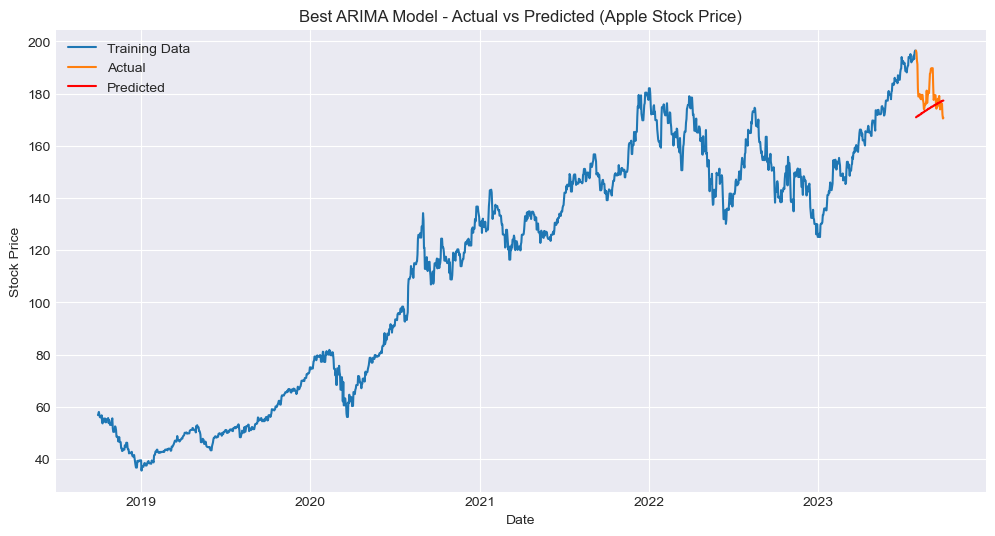

In [51]:
# Fit ARIMA model with the best parameters
best_model=SARIMAX(dataset["Apple"],order=(2, 1, 2),seasonal_order=(1, 1, 1, 7))
best_result = best_model.fit()

# Print best model summary
print(best_result.summary())

# Make predictions on the testing set using the best model
best_predictions = best_result.forecast(steps=len(test_data))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data["Apple"], label='Training Data')
plt.plot(test_data.index, test_data["Apple"], label='Actual')
plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
plt.title(f'Best ARIMA Model - Actual vs Predicted ({"Apple"} Stock Price)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
display(best_predictions)

                               SARIMAX Results                                
Dep. Variable:                 Amazon   No. Observations:                 1764
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -4012.313
Date:                Fri, 09 Feb 2024   AIC                           8040.625
Time:                        11:49:33   BIC                           8084.419
Sample:                    10-01-2018   HQIC                          8056.808
                         - 07-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8047      0.018   -100.277      0.000      -1.840      -1.769
ar.L2         -0.9984      0.037    -26.973      0.000      -1.071      -0.926
ar.L3          0.0070      0.045      0.157      0.8

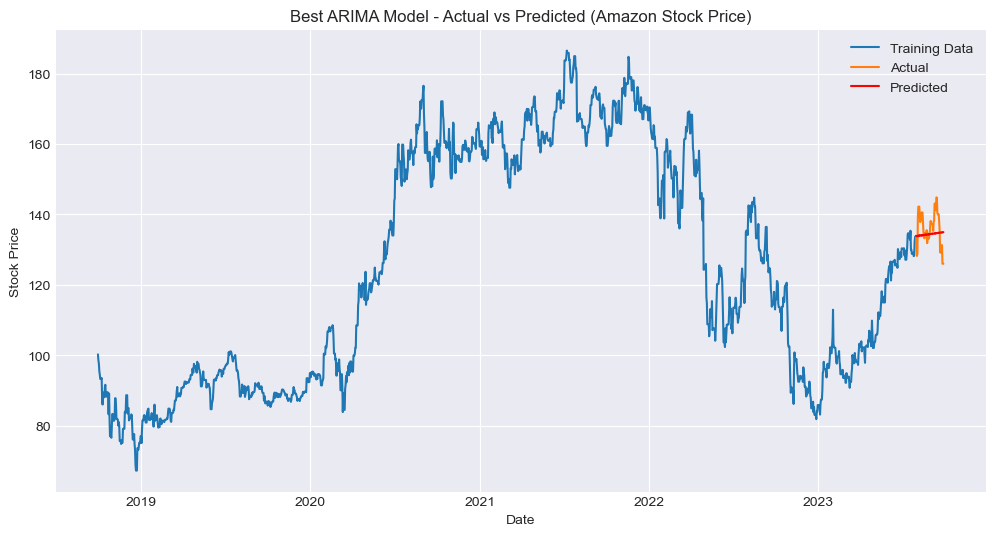

In [52]:
# Fit ARIMA model with the best parameters
best_model = ARIMA(train_data["Amazon"], order=(4, 2, 3))
best_result = best_model.fit()

# Print best model summary
print(best_result.summary())

# Make predictions on the testing set using the best model
best_predictions = best_result.forecast(steps=len(test_data))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data["Amazon"], label='Training Data')
plt.plot(test_data.index, test_data["Amazon"], label='Actual')
plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
plt.title(f'Best ARIMA Model - Actual vs Predicted ({"Amazon"} Stock Price)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
display(best_predictions)

                                     SARIMAX Results                                     
Dep. Variable:                               DBS   No. Observations:                 1824
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood                -254.399
Date:                           Fri, 09 Feb 2024   AIC                            520.797
Time:                                   11:49:48   BIC                            553.823
Sample:                               10-01-2018   HQIC                           532.983
                                    - 09-28-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7995      0.152      5.270      0.000       0.502       1.097
ma.L1         -0.7694      0.161     -4.788

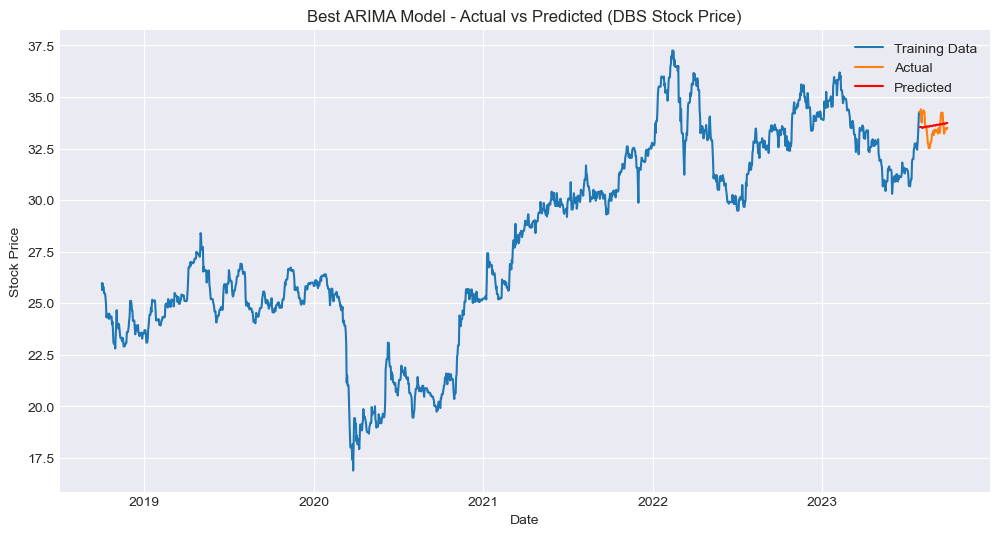

In [53]:
# Fit ARIMA model with the best parameters
best_model=SARIMAX(dataset["DBS"],order=(1, 1, 1),seasonal_order=(2, 1, 1, 7))
best_result = best_model.fit()

# Print best model summary
print(best_result.summary())

# Make predictions on the testing set using the best model
best_predictions = best_result.forecast(steps=len(test_data))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data["DBS"], label='Training Data')
plt.plot(test_data.index, test_data["DBS"], label='Actual')
plt.plot(test_data.index, best_predictions, color='red', label='Predicted')
plt.title(f'Best ARIMA Model - Actual vs Predicted ({"DBS"} Stock Price)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
display(best_predictions)

# Does **Scaling** Affect the Model
<u>**No!**</u> The Mean Absolute Percentage Error is the same.<br>
From our conclusion, the scores had no change even after scaling. Hence, it needs more process to scale down and scale up again is redundent

In [77]:
# Setting Datetime for TimeSeries
dataset = pd.read_csv('./CA2-Dataset/CA2-Stock-Price-Data.csv', sep=',')
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset = dataset.set_index("Date").asfreq('d')

# Imputing Data
dataset = dataset.bfill()

# Defining scaler
scaler = StandardScaler()

# Scaling the dataset
dataset[['Apple','Amazon','DBS']] = scaler.fit_transform(dataset[['Apple','Amazon','DBS']])

# Fit ARIMA model with the best parameters
scaled_model = ARIMA(train_data["Amazon"], order=(4, 2, 3))
scaled_result = scaled_model.fit()
scaled_predictions = result.forecast(steps=len(test_data))

cols = ['Apple','Amazon','DBS']
dataset[cols] = scaler.inverse_transform(dataset[cols]) 

test_data = dataset[-60:]
# Print best model summary
print(mean_absolute_percentage_error(test_data['Amazon'] , scaled_predictions))

0.7525674628055056


In [78]:
# Setting Datetime for TimeSeries
dataset = pd.read_csv('./CA2-Dataset/CA2-Stock-Price-Data.csv', sep=',')
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset = dataset.set_index("Date").asfreq('d')

# Imputing Data
dataset = dataset.bfill()

# Fit ARIMA model with the best parameters
scaled_model = ARIMA(train_data["Amazon"], order=(4, 2, 3))
scaled_result = scaled_model.fit()
scaled_predictions = result.forecast(steps=len(test_data))

# Print best model summary
print(mean_absolute_percentage_error(test_data['Amazon'] , scaled_predictions))

0.7525674628055056


# <u>**Conclusions**</u>
- ### Best Models:
    - Apple (SARIMAX = (2, 1, 2),(1, 1, 1, 7))
    - Amazon (ARIMA = (4, 2, 3))
    - DBS (SARIMAX = (1, 1, 1),(2, 1, 1, 7))

<u>Learning insides</u>

- scaling doesn't affect the model
- Best Model is SARIMAX, but takes the longest
    - Our Model is Non seasonal (seasonal = 7)